In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Data Loading

In [10]:

# Load data from CSV file
data2 = pd.read_csv('Extracted_data-final.csv')
pe_data = pd.read_csv('PE.csv')
ne_data = pd.read_csv('NE.csv')

# Extract columns
NE_SOC = ne_data.iloc[:, 0].values
NE_OCV = ne_data.iloc[:, 1].values

PE_SOC = pe_data.iloc[:, 0].values
PE_OCV = pe_data.iloc[:, 1].values

FC_Cap = data2.iloc[:, 4].values
FC_OCV = data2.iloc[:, 5].values

# plt.plot(FC_Cap, FC_OCV, '-')

# filter odd index for smooting data points
# NE_SOC = NE_SOC[::2]
# NE_OCV = NE_OCV[::2]
# PE_SOC = PE_SOC[::2]
# PE_OCV = PE_OCV[::2]

# # Noramalize values to 0-1 using max value and min value
NE_SOC = (NE_SOC - NE_SOC.min()) / (NE_SOC.max() - NE_SOC.min())
PE_SOC = (PE_SOC - PE_SOC.min()) / (PE_SOC.max() - PE_SOC.min())



Up = np.column_stack((PE_SOC, PE_OCV))
Un = np.column_stack((NE_SOC, NE_OCV))

OFFSET = 0


## Funtion Defination
objective funtion to simulate the full cell volatge and calculate the difference between orignal and simulated values.

In [11]:

def objective_function(params, Q_actual, V_actual, Up, Un):
    """
    Calculate the root mean square error (RMSE) between the actual voltage (V_actual) and the simulated voltage (V_simulated)
    based on the given parameters (params), actual charge (Q_actual), actual voltage (V_actual), and voltage profiles (Up, Un).
    Parameters:
    - params (list): List of parameters [y0, x0, Cp, Cn] used in the calculation.
    - Q_actual (array-like): Array-like object representing the actual charge values.
    - V_actual (array-like): Array-like object representing the actual voltage values.
    - Up (array-like): Array-like object representing the voltage profiles for positive electrode.
    - Un (array-like): Array-like object representing the voltage profiles for negative electrode.
    Returns:
    - rmse (float): Root mean square error between the actual voltage and the simulated voltage.
    """
    y0, x0, Cp, Cn = params
    
    y = y0 + Q_actual / Cp
    x = x0 + Q_actual / Cn

    Un1 = interp1d(Un[:, 0], Un[:, 1], kind='linear', fill_value='extrapolate')(x)
    Up1 = interp1d(Up[:, 0], Up[:, 1], kind='linear', fill_value='extrapolate')(y)
    
    V_simulated = Up1 - Un1 + OFFSET
    rmse = np.sqrt(np.mean((V_actual - V_simulated) ** 2))
    return rmse


## Optimization
This code snippet is setting initial parameters (`y0`, `x0`, `Cp`, `Cn`), creating a list `params0` containing these parameters, defining bounds for the optimization variables, and then performing an optimization using the `minimize` function.


In [12]:
# Initial parameters
y0 = 0.1
x0 = 0.034
Cp = 5.281203911
Cn = 5.125548657

params0 = [y0, x0, Cp, Cn]
bounds = [(0, 1), (0, 1),(4.85, 7), (4.85, 7)]
# bounds = [(0.004, 0.004), (0.3, 1), (4.85, 6), (4.85, 6)]

# Optimization
result = minimize(objective_function, params0, args=(FC_Cap, FC_OCV, Up, Un), bounds=bounds, method='SLSQP', options={'maxiter': 1000, 'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02361187092489915
            Iterations: 20
            Function evaluations: 104
            Gradient evaluations: 20


In [13]:
optimal_params = result.x
optimal_rmse = result.fun

# Extract optimized parameters
y0_optimal = optimal_params[0]
x0_optimal = optimal_params[1]
Cp_optimal = optimal_params[2]
Cn_optimal = optimal_params[3]

# Simulation
Q_actual = FC_Cap
V_actual = FC_OCV
V_simulated = np.zeros_like(Q_actual)
y_values = np.zeros_like(Q_actual)
x_values = np.zeros_like(Q_actual)
Up_values = np.zeros_like(Q_actual)
Un_values = np.zeros_like(Q_actual)

## Simulation
Simulate voltage values using optimized parameters and interpolation.

In [14]:

for i in range(len(Q_actual)):
    Q = Q_actual[i]
    y = y0_optimal + Q / Cp_optimal
    x = x0_optimal + Q / Cn_optimal
    y_values[i] = y
    x_values[i] = x

    # if y < min(PE_SOC) or y > max(PE_SOC) or x < min(NE_SOC) or x > max(NE_SOC):
    #     V_simulated[i] = np.nan
    #     Up_values[i] = np.nan
    #     Un_values[i] = np.nan
    # else:
    Up_values[i] = interp1d(PE_SOC, PE_OCV, kind='linear', fill_value='extrapolate')(y)
    Un_values[i] = interp1d(NE_SOC, NE_OCV, kind='linear', fill_value='extrapolate')(x)
    V_simulated[i] = Up_values[i] - Un_values[i]

# valid_idx = ~np.isnan(V_simulated)
# Q_actual_valid = Q_actual[valid_idx]
# V_actual_valid = V_actual[valid_idx]
# V_simulated_valid = V_simulated[valid_idx]
# y_values_valid = y_values[valid_idx]
# x_values_valid = x_values[valid_idx]
# Up_values_valid = Up_values[valid_idx]
# Un_values_valid = Un_values[valid_idx]

Q_actual_valid = Q_actual
V_actual_valid = V_actual
V_simulated_valid = V_simulated
y_values_valid = y_values
x_values_valid = x_values
Up_values_valid = Up_values
Un_values_valid = Un_values


results = pd.DataFrame({
    'Q_actual': Q_actual_valid,
    'V_actual': V_actual_valid,
    'y': y_values_valid,
    'x': x_values_valid,
    'V_simulated': V_simulated_valid,
    'Up': Up_values_valid,
    'Un': Un_values_valid
})

# print(results)

print(f'Optimal RMSE: {optimal_rmse}')
print(f'Optimized y0: {y0_optimal}')
print(f'Optimized x0: {x0_optimal}')
print(f'Optimized Cp: {Cp_optimal}')
print(f'Optimized Cn: {Cn_optimal}')

Optimal RMSE: 0.02361187092489915
Optimized y0: 0.20135187079454292
Optimized x0: 0.0690795368791873
Optimized Cp: 5.935645477229393
Optimized Cn: 5.285173174605109


## Plotting

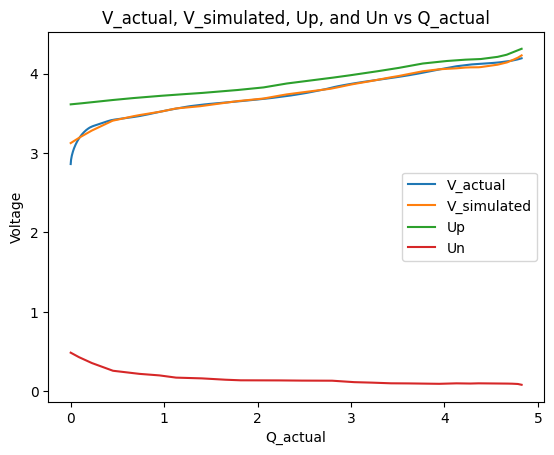

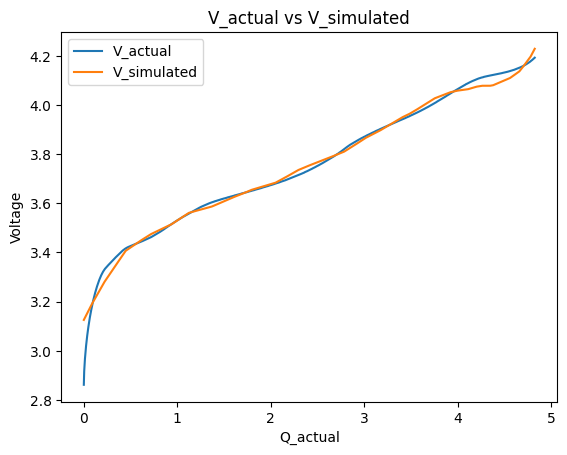

In [15]:


plt.figure()
plt.plot(Q_actual_valid, V_actual_valid, '-', label='V_actual')
plt.plot(Q_actual_valid, V_simulated_valid+OFFSET, '-', label='V_simulated')
plt.plot(Q_actual_valid, Up_values_valid, '-', label='Up')
plt.plot(Q_actual_valid, Un_values_valid, '-', label='Un')
plt.xlabel('Q_actual')
plt.ylabel('Voltage')
plt.title('V_actual, V_simulated, Up, and Un vs Q_actual')
plt.legend()
plt.show()

plt.figure()
plt.plot(Q_actual_valid, V_actual_valid, '-', label='V_actual')
plt.plot(Q_actual_valid, V_simulated_valid+OFFSET, '-', label='V_simulated')
plt.xlabel('Q_actual')
plt.ylabel('Voltage')
plt.title('V_actual vs V_simulated')
plt.legend()
plt.show()

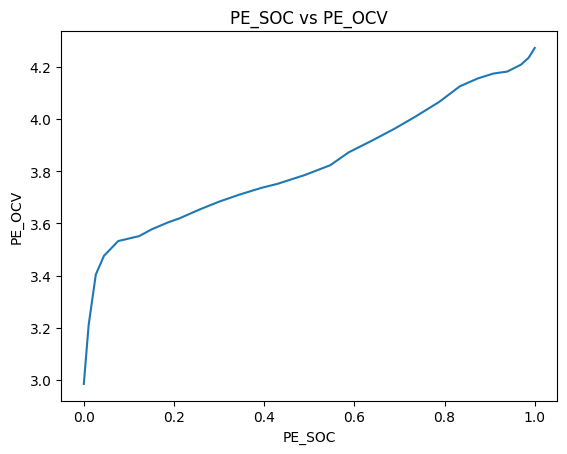

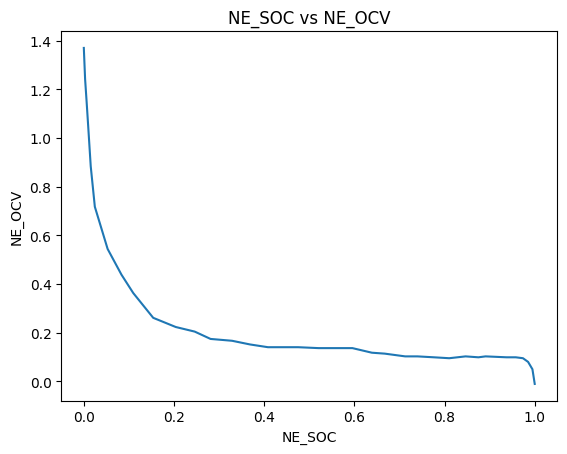

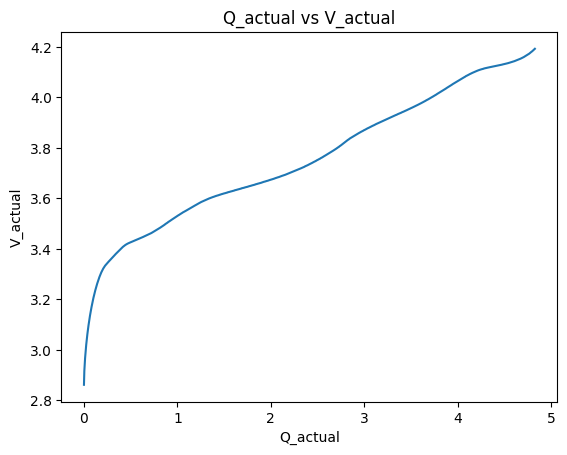

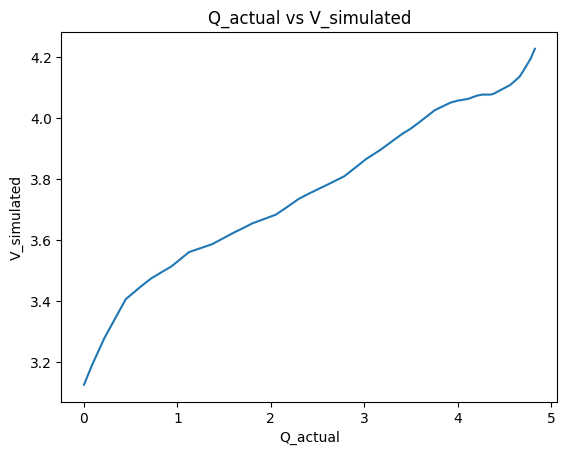

In [16]:
# Plotting
plt.figure()
# plt.subplot(2, 2, 2)
plt.plot(PE_SOC, PE_OCV, '-')
plt.xlabel('PE_SOC')
plt.ylabel('PE_OCV')
plt.title('PE_SOC vs PE_OCV')
plt.show()

# plt.subplot(2, 2, 2)
plt.plot(NE_SOC, NE_OCV, '-')
plt.xlabel('NE_SOC')
plt.ylabel('NE_OCV')
plt.title('NE_SOC vs NE_OCV')
plt.show()

# plt.subplot(2, 2, 3)
plt.plot(Q_actual_valid, V_actual_valid, '-')
plt.xlabel('Q_actual')
plt.ylabel('V_actual')
plt.title('Q_actual vs V_actual')
plt.show()

# plt.subplot(2, 2, 4)
plt.plot(Q_actual_valid, V_simulated_valid, '-')
plt.xlabel('Q_actual')
plt.ylabel('V_simulated')
plt.title('Q_actual vs V_simulated')
plt.show()